<a href="https://colab.research.google.com/github/sio-co2o2/scrippsco2_notebooks/blob/main/notebooks/plot_global_co2_fluxes_scrippsco2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/sio-co2o2/scrippsco2_notebooks/main?labpath=notebooks%2Fplot_global_co2_fluxes_scrippsco2.ipynb)

# Plot Global CO2 Fluxes

### Scripps CO2 Program
https://scrippsco2.ucsd.edu

This notebook creates pdf and png plot versions.

Will be plotting the following:

Blue Curve: CO2 rate of change based on Mauna Loa Record.

Black Curve: CO2 rate of change based on the Antarctic ice core record from Law Dome before 1958 (Macfarling Meure, C. et al., 2006: Law Dome CO2, CH4 and N2O ice core records extended to 2000 years BP. Geophysical Research Letters, 33.) and a seasonally detrended arithmetic average of monthly air measurements from Mauna Loa and the South Pole from the Scripps CO2 program after and including 1958. The records were combined without adjustment. Ice core data are rejected after 1958 which overlap direct measurements. The ice core data are interpolated to monthly resolution using a spline with a stiffness of 0.8. The curve is smoothed to suppress short-term interannual variability, for example, due to El Nino events.

Red Curve: Fossil fuel CO2 emissions.

## Import packages

In [1]:
import re
import pandas as pd
import numpy as np
import requests
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
import os
from PIL import Image

%matplotlib inline

In [2]:
# This package is used to convert a vector svg into a png

try:
  from cairosvg import svg2png
except:
  ! pip install cairosvg
  from cairosvg import svg2png

In [3]:
# This import is to enable Google Colab to save files ane then download them

# This import does not exist unless the notebook is run in Google Colab
# Put in a try except block if user wants to use notebook off of Google Colab

try:
    from google.colab import files
except:
    pass

## Set directories and file names for data,  plot, and logo

In [4]:
# From bluemoon
# ff_file = './data/supplemental/fossil_fuel/modified/cum_ff_rate_trend.csv'
# cum_rate_trend_file = './data/supplemental/merged_ice_core_mlo_spo/cumulativeIcecoreMloSpoRateTrend.csv'
# mlo_rate_trend_file = './data/supplemental/co2_rate_trend/mlo_co2_rate_trend.csv'

# From github
ff_file = 'https://raw.githubusercontent.com/sio-co2o2/scrippsco2_notebooks/main/data/fossil_fuel/cum_ff_rate_trend.csv'
cum_rate_trend_file = 'https://raw.githubusercontent.com/sio-co2o2/scrippsco2_notebooks/main/data/icecore/cumulativeIcecoreMloSpoRateTrend.csv'
mlo_rate_trend_file = 'https://raw.githubusercontent.com/sio-co2o2/scrippsco2_notebooks/main/data/co2/mlo_co2_rate_trend.csv'

# Set plot directories for website graphics gallery
plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_pdf_dir = pathlib.Path(plot_dir / 'pdf')
plot_pdf_dir.mkdir(exist_ok=True)

plot_png_dir = pathlib.Path(plot_dir / 'png')
plot_png_dir.mkdir(exist_ok=True)

plot_display_dir = pathlib.Path(plot_dir / 'display')
plot_display_dir.mkdir(exist_ok=True)

plot_thumbnail_dir = pathlib.Path(plot_dir / 'thumbnails')
plot_thumbnail_dir.mkdir(exist_ok=True)

# logo_file = 'images/ucsd_sio_logo.svg'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/logos/ucsd_sio_logo.svg'

plot_name = 'global_co2_fluxes'

pdf_file = plot_pdf_dir / f'{plot_name}.pdf'
png_file = plot_png_dir / f'{plot_name}.png'
png_display_file = plot_display_dir / f'{plot_name}.png'
png_thumbnail_file = plot_thumbnail_dir / f'{plot_name}.png'


## Load in Data and process

### Load in rate of change of Fossil Fuel data

In [5]:
# TODO
# Get data off github

df_ff = pd.read_csv(ff_file)
df_ff.head()


,year,ff_rate_trend
0,1740,0.000000
1,1752,0.002999
2,1753,0.003000
3,1754,0.003000
4,1755,0.003000


### Convert to numpy arrays for plotting

In [6]:
date_ff = df_ff['year'].to_numpy()
trend_ff = df_ff['ff_rate_trend'].to_numpy()

### Load in rate of change of icecore data merged with MLO and SPO averaged

In [7]:
df_ice_mlo_spo = pd.read_csv(cum_rate_trend_file, header=None)
df_ice_mlo_spo.columns = ['year', 'rate_trend']
df_ice_mlo_spo.head()

,year,rate_trend
0,1740.3,-0.183
1,1740.8,-0.185
2,1741.3,-0.187
3,1741.8,-0.185
4,1742.3,-0.185


### Convert to numpy arrays for plotting

In [8]:
date_ice_mlo_spo = df_ice_mlo_spo['year'].to_numpy()
trend_ice_mlo_spo = df_ice_mlo_spo['rate_trend'].to_numpy()

## Load in rate of change of MLO

In [9]:
df_mlo = pd.read_csv(mlo_rate_trend_file, header=None)
df_mlo.columns = ['year', 'co2_rate_trend']
df_mlo.head()


,year,co2_rate_trend
0,1958.2452,2.0352
1,1958.3288,2.0352
2,1958.4123,2.0352
3,1958.4959,1.7808
4,1958.5795,1.7808


### Convert to numpy arrays for plotting

In [10]:
date_mlo = df_mlo['year'].to_numpy()
trend_mlo = df_mlo['co2_rate_trend'].to_numpy()

## Define Plot Functions

In [11]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

In [12]:
def set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel):


    # ------------------------------------
    # Set properties to use for matplotlib
    # ------------------------------------
    
    set_matplotlib_properties()


    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------
    
    # Allow room at top for the titles
    fig.subplots_adjust(top=0.85)

    
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(axis='x', which='major', direction='in', length=8, width=1, pad=8)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)

    tick_spacing = 20
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    tick_spacing = 1
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold')

    tick_length = 5
    ax.tick_params(axis='x', which='minor', direction='in', length=tick_length)
       
    tick_length = 4
    ax.tick_params(axis='y', which='minor', direction='in', length=tick_length)
        
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
     
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=21, labelpad=8)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=21, labelpad=8)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

In [13]:
def add_plot_title(ax, title1, title2):

    ax.annotate(title1, xy=(0, 1.095), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top', fontweight="bold")
     
    ax.annotate(title2, xy=(0, 1.04), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")

In [14]:
def add_sio_logo(fig, logo_file, xpos, ypos):

    # Convert the logo svg file to a png file with the
    # given scale and dpi

    logo_png = 'logo.png'

    #logo_path = str(logo_file.resolve())
    #svg2png(url=logo_path, write_to=logo_png, scale=10, dpi=300)
    svg2png(url=logo_file, write_to=logo_png, scale=10, dpi=300)

    logo = mpimg.imread(logo_png)

    fig.add_axes([xpos, ypos, 0.2, 0.2], anchor='SE', zorder=1)

    plt.imshow(logo)
    plt.axis('off')

    # Delete the logo png version
    os.remove(logo_png)


In [15]:
def save_plot_for_website(fig):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 11
    #height_in = 8.5
    height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    plt.subplots_adjust(left=0.109, right=0.95, top=0.85, bottom=0.15)

    # Save to a high dpi so that logo png file has a high resolution
    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=600)

    # Save png version
    png_dpi = 600

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # For display png
    # width = 1200px

    # Now resize the image
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 1200
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.LANCZOS)
    img.save(png_display_file)

    # For thumbail png
    # width = 250px

    # Now resize the image
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 250
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.LANCZOS)
    img.save(png_thumbnail_file)


## Set plot limits and labeling

### Functions to convert dates into various formats
For plot limits and labeling

In [16]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [17]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [18]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [19]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

### Get Todays date for title

In [20]:
# ------------------------------------------------
# Get todays date in various formats for labeling
# ------------------------------------------------
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

### Set titles and axes labels

In [21]:
xlabel = 'Year'
ylabel = "Flux (PgC/year)"

title1 = "Observed Global " + "$\mathregular{CO}\\bf{_2}$" + " Fluxes"
title2 = f'Last updated {todays_date_moyr}'

### Set yaxis min and max limits

In [22]:
ymin = -1
ymax = 11

### Set xaxis min and max limits
The decimal date is the midpoint of each month for the monthly record and for the concatenated daily data from the end of the monthly data to now is at the mid day.

In [23]:
xmin = 1720
xmax = todays_year + 2

## Create plot and save

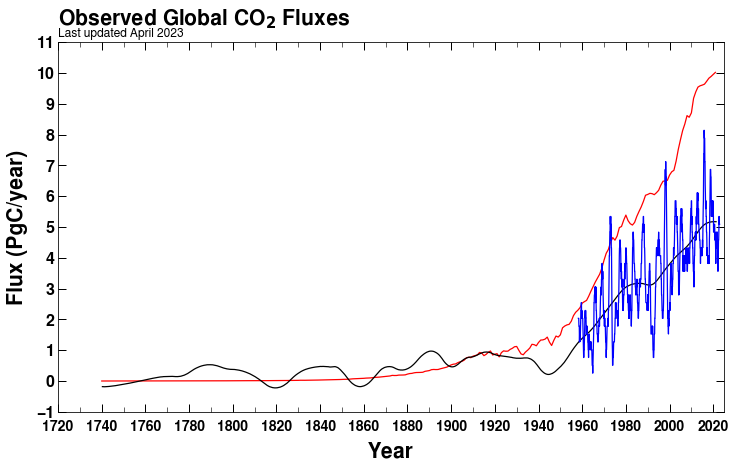

In [24]:
fig = plt.figure()

ax = fig.add_subplot()


# -------------
# Plot the data
# -------------

ax.plot(date_ff, trend_ff, '-', color='red', linewidth=1.25)

ax.plot(date_ice_mlo_spo, trend_ice_mlo_spo, '-', color='black', linewidth=1.25)

ax.plot(date_mlo, trend_mlo, '-', color='blue', linewidth=1.25)

# -------------------
# Set plot properties
# -------------------
set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel)

# ---------------
# Add plot titles
# ---------------
add_plot_title(ax, title1, title2)


# --------------------
# Add SIO logo to plot
# --------------------
xpos = 0.73
ypos = 0.17

#add_sio_logo(fig, logo_file, xpos, ypos)


# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_for_website(fig)


plt.show()